



# **Fashion Product Recommendation using visual similarity**










In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import pandas as pd
import cv2 as cv
from skimage.metrics import structural_similarity as ssim
import pickle

## **Data Preprocessing**

In [ ]:
items = pd.read_csv('/content/items.csv')

In [ ]:
items.describe()

,product,category,product_urls,search_links
count,38111,38111,38111,38111
unique,38111,10,38111,38111
top,8870b0d384138a81cfdc91f98d1dde9b,Apparel & Accessories|Shoes,http://i.pinimg.com/400x/88/70/b0/8870b0d38413...,https://lens.google.com/uploadbyurl?url=http:/...
freq,1,11780,1,1


In [ ]:
items.head()

,product,category,product_urls,search_links
0,8870b0d384138a81cfdc91f98d1dde9b,Apparel & Accessories|Shoes,http://i.pinimg.com/400x/88/70/b0/8870b0d38413...,https://lens.google.com/uploadbyurl?url=http:/...
1,70d392390fa258ba9b5d6b83ea29857e,Apparel & Accessories|Shoes,http://i.pinimg.com/400x/70/d3/92/70d392390fa2...,https://lens.google.com/uploadbyurl?url=http:/...
2,2c05db9ff1abbcfc4bfd50dd003aac80,Apparel & Accessories|Clothing|Pants,http://i.pinimg.com/400x/2c/05/db/2c05db9ff1ab...,https://lens.google.com/uploadbyurl?url=http:/...
3,2b2cc3a8b588b7282be0511568b51ee7,Apparel & Accessories|Clothing|Shirts & Tops,http://i.pinimg.com/400x/2b/2c/c3/2b2cc3a8b588...,https://lens.google.com/uploadbyurl?url=http:/...
4,a141ed588bdaeccf1f695889a5aa7085,Apparel & Accessories|Clothing|Shorts,http://i.pinimg.com/400x/a1/41/ed/a141ed588bda...,https://lens.google.com/uploadbyurl?url=http:/...


In [ ]:
items.isnull().sum()

product         0
category        0
product_urls    0
search_links    0
dtype: int64

In [ ]:
!unzip "/content/data.zip" -d "/"
data_dir = '/content/data'
IMG_SIZE = (224,224)

In [ ]:
image_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            shuffle=True,
                                                            image_size=IMG_SIZE)

Found 38111 files belonging to 10 classes.


In [ ]:
categories = {}
for row in items.iterrows():
  # print(row)
  category_list = row[1]['category'].split('|')
  category = category_list[-1]
  if category not in categories:
    categories[category] = []
  categories[category].append((row[1]['product'],row[1]['product_urls']))

**Display nine images from the dataset**

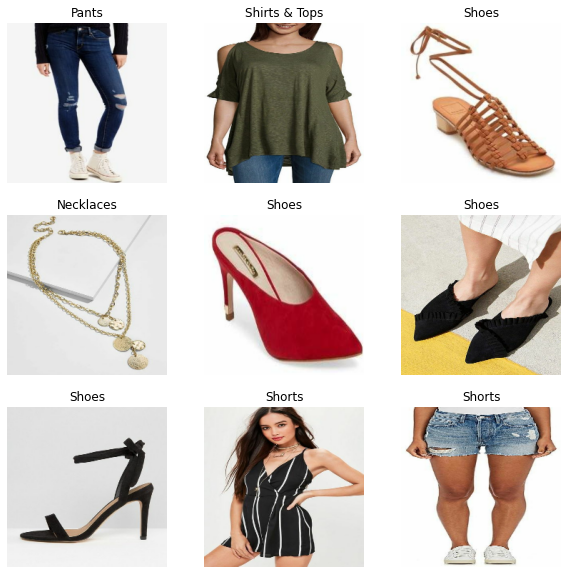

In [ ]:
class_names = image_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in image_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# image_dataset = image_dataset.prefetch(buffer_size=AUTOTUNE)

### **Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
for image, _ in image_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### **Creating the base model**

We are using the pre-trained TensorFlow ResNet50 model

In [ ]:
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

In [ ]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  175


### **Data Normaliztion**
 
Images are represented using RGB channels which contain values in the [0,255] range. It is not ideal for neural networks. So standardize the values in the range [0,1]

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_image_dataset =image_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_image_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0046484424 1.0


### **Feature Extraction**

Saving image features to a pickle file for re-use

In [ ]:
def extract(file):
  file = Image.open(file).convert('L').resize(IMG_SIZE)
  #display(file)

  file = np.stack((file,)*3, axis=-1)

  file = np.array(file)/255.0

  embedding = model.predict(file[np.newaxis, ...])
  vgg16_feature_np = np.array(embedding)
  flattended_feature = vgg16_feature_np.flatten()

  #print(len(flattended_feature))
  #print(flattended_feature)
  #print('-----------')
  return flattended_feature

In [ ]:
class_names = image_dataset.class_names
base_url = '/content/data/'
print(class_names)

['Coats & Jackets', 'Earrings', 'Handbags, Wallets & Cases', 'Necklaces', 'Pants', 'Shirts & Tops', 'Shoes', 'Shorts', 'Skirts', 'Sunglasses']


In [ ]:
def getFeatures(category):
  feature_extraction_map = {}
  for line in categories[category]:
    filename = base_url+category+'/'+str(line[0])+'.jpg'
    feature = extract(filename)
    feature_extraction_map[line[0]] = feature
  return feature_extraction_map

In [ ]:
product_features = {}
for category in categories:
  print("=======================")
  print(category)
  print("=========================")
  product_features[category] = getFeatures(category)

In [ ]:
with open('saved_results.pkl', 'wb') as f:
    pickle.dump(result, f)

### **Finding Top 5 visulally similar products**

In [ ]:
def compute_similarity(img1,img2):
  similarity = ssim(img1,img2,data_range=img2.max() - img2.min())
  return similarity

In [ ]:
for category in categories:
#category = 'Shoes'
  print("==================================")
  print(category)
  print("==================================")
  product_ids = []
  product_categories = []
  top_1 = []
  top_2 = []
  top_3 = []
  top_4 = []
  top_5 = []
  images = list(product_features[category].items())
#prods = [line[0] for line in categories[category]]
  n = len(images)
  scores_matrix = [[0 for x in range(n)] for y in range(n)] 
  for i in range(n):
    for j in range(i+1,n):
      score = compute_similarity(images[i][1],images[j][1])
      scores_matrix[i][j] = score
      scores_matrix[j][i] = score
    scores = [(images[k][0],scores_matrix[i][k]) for k in range(n)]
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    product_ids.append(images[i][0])
    product_categories.append(category)
    top_1.append(scores[0][0])
    top_2.append(scores[1][0])
    top_3.append(scores[2][0])
    top_4.append(scores[3][0])
    top_5.append(scores[4][0])

  similar_products_df = pd.DataFrame(list(zip(product_ids, product_categories,top_1,top_2,top_3,top_4,top_5)),columns =['id', 'category','Top 1','Top 2','Top 3', 'Top 4', 'Top 5'])


### **Saving the results to csv file**

In [ ]:
similar_products_df.to_csv(str(category)+'.csv', index=False)